In [1]:
class MotifNode():
    def __init__(self,node,motif,nodelabel,isleaf,ancestor,ancseq,probability=None,present=False,switch=False):
        self.node=node
        self.motif=motif
        self.hasMotif=present
        self.switchnode=switch
        self.ancestor=ancestor
        self.nodelabel=nodelabel
        self.isleaf=isleaf
        self.motifcodonprob=probability
        self.ancseq=ancseq
        
    def findupstreamswitch(self,MotifDataDICT,node):
        #motifcode currently stored and this function relies on that. Limitation not to store motif instance though. Future fix.
        node=node.parent_node
        motifcode=self.motif
        while MotifDataDICT[motifcode][node.label].switchnode==False:
            if node.parent_node:
                node=node.parent_node
            else: 
                node=None
                break
        self.upstreamswitch=node
            

In [2]:
from CommonMotifProb import SeqMatch, findAlignPostn
def isMotifmatch(motif1,motif2,seqid1,seqid2,protalignment):
    if motif1.motifID==motif2.motifID and len(motif1.motifSeq)==len(motif2.motifSeq):
        Motif1StartIndexinalignment=findAlignPostn(seqid1,motif1.position[0]+1,protalignment)
        Motif2StartIndexinalignment=findAlignPostn(seqid2,motif2.position[0]+1,protalignment)

        if Motif1StartIndexinalignment==Motif2StartIndexinalignment:
            return True
        else:
            return False
    else:
        return False
        
        
        
        
        
        
        
        
        

In [3]:
#Figure out a function that takes a strain+sequence, a list of "tracked" motifs 
#and which returns mutations within the tracked motif region.
#I also need to rank amino acids based on importance for motif.
#Basically describe each position in a motif based on how it limits 
#the evolutionary space if the motif is to remain.

#Over all nodes: TImes motif has been lost and gained total (Normalise by number of seqs?)

def SpecificMotifProb(motif, seqID, alignment, time):
    sequence=None
    for entry in alignment:
        if entry.id==seqID:
            sequence=entry
            break
    if sequence:
        seqsegment = entry.seq.ungap('-').transcribe()[motif.position[0]*3:motif.position[1]*3]
    else:
        print 'Error: No sequence found for ',seqID
    if len(seqsegment)/3==len(motif.motifSeq):
        print seqsegment.translate()
        prob=CommonMotifProb.MotifProbability(str(seqsegment),CommonMotifProb.ELMsDICT[motif.motifID], time)
    else:
        print 'Error: no match motifseq and number of codons'
        
    return prob
        



In [4]:
reload(CommonMotifProb)

NameError: name 'CommonMotifProb' is not defined

In [1]:
import sys
import os
from ete3 import Tree,PhyloTree, TreeStyle,SeqMotifFace,SequenceFace, add_face_to_node, random_color, NodeStyle
from Bio import AlignIO, Alphabet
os.putenv('DISPLAY', ':0.0')
from treetime import TreeTime
import re
import csv
import cPickle as pickle

ImportError: Bio.Alphabet has been removed from Biopython. In many cases, the alphabet can simply be ignored and removed from scripts. In a few cases, you may need to specify the ``molecule_type`` as an annotation on a SeqRecord for your script to work correctly. Please see https://biopython.org/wiki/Alphabet for more information.

In [2]:
from ipywidgets import widgets, HBox, VBox, Layout, Label
from IPython.display import display
from Bio import SeqIO, Seq
import CommonMotifProb
import copy
from dna_features_viewer import (GraphicFeature, GraphicRecord,
                                 CircularGraphicRecord)
import matplotlib.pyplot as plt
import numpy as np
from identify_motifs import *
import matplotlib
import pandas as pd
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [6]:
#important to consider alignment adjustments
#how do i create motifs based on user definitions or alternatively based on a set of identified motifs
#by sequence. Both options will be useful.

def motifSelectFilter(motiflisttotal,motiflistchoices,node):
    trackedmotiflist=[]
    refseqid='NODE_0000050'
    for chosenmotif in motiflistchoices:
        for motif in motiflisttotal:
        
            if chosenmotif.motifID in motif.motifID and motif.position[0]>=chosenmotif.position[0]-20 and motif.position[1]<=chosenmotif.position[1]+20:
                if motif.position[0]==chosenmotif.position[0]:
                    trackedmotiflist.append(motif)
                    break
                elif isMotifmatch(motif,chosenmotif,node,refseqid,alignmentprot):
                    trackedmotiflist.append(motif)
                    break
    return trackedmotiflist

In [7]:
#Assign terminal motifs
def importterminalELMs():
    with open ('Terminal_Motifs.tsv', 'r') as doc:
        ELMlist = csv.reader(doc,delimiter='\t')
        return [i for i in ELMlist]
def terminalMotifs(seq):
    list_of_motifs=[]
    ELMs = importterminalELMs()
    for motif in ELMs:
        currentRegEx = motif[4]
        currentID = motif[1]
        seqMatches = re.finditer(currentRegEx,seq)
        for eachMatch in seqMatches:
            list_of_motifs.append(Motif(motifSeq=eachMatch.group(), position=eachMatch.span(), motifID=currentID, motifRegEx=currentRegEx))
    return list_of_motifs

In [8]:
def limitedMotiffind(seq,ELMs):
    list_of_motifs=[]
    for motif in ELMs:

        currentRegEx = ELMs[motif]
        currentID = motif
        seqMatches = re.finditer(currentRegEx,seq)

        for eachMatch in seqMatches:
            list_of_motifs.append(Motif(motifSeq=eachMatch.group(), position=eachMatch.span(), motifID=currentID, motifRegEx=currentRegEx))
    return list_of_motifs

In [6]:

'''
rate A <-> C: 1.792412  
rate A <-> G: 9.542882
rate A <-> T: 0.796239
rate C <-> G: 0.263115
rate C <-> T: 9.340186
rate G <-> T: 1.000000

freq pi(A): 0.317235
freq pi(C): 0.200558
freq pi(G): 0.243714
freq pi(T): 0.238493
'''

'\nrate A <-> C: 1.792412  \nrate A <-> G: 9.542882\nrate A <-> T: 0.796239\nrate C <-> G: 0.263115\nrate C <-> T: 9.340186\nrate G <-> T: 1.000000\n\nfreq pi(A): 0.317235\nfreq pi(C): 0.200558\nfreq pi(G): 0.243714\nfreq pi(T): 0.238493\n'

In [9]:
import dendropy as dp
with open("RAxML_FluRambautWithNodes.tre",'r') as f:
    dptest2=dp.Tree.get(file=f,schema='newick',preserve_underscores=True)

In [9]:
def MotifsAtNodes(tree,alignment3,checkneutral):
    MotifList={}
    for node in tree.preorder_node_iter():
        if node.label:
            MotifList[node.label]=[]
        else:
            MotifList[node.taxon.label]=[]



   
    for record in alignment3:
        currentstart=0
        for motif in checkneutral:

            assert currentstart<len(record.seq)
            currentend=len(checkneutral[motif].ancseq)+currentstart

            motifsel=[checkneutral[motif].motif.motifID]

            #motifsel=['MOD_PKA_2']
            ltdELMsDICT={}
            for k in motifsel:
                ltdELMsDICT[k]=CommonMotifProb.ELMsDICT[k]



            seq=record.seq[currentstart:currentend]
            rnaseq=str(seq)
            protseq=str(seq.translate())
            foundMotif=limitedMotiffind(protseq,ltdELMsDICT)
            listnames=[i.motifID for i in foundMotif]
            if checkneutral[motif].motif.motifID in listnames:
                if record.id[0]=="'":
                    MotifList[record.id[1:-1]].append(MotifNeutralModel(foundMotif,checkneutral[motif].motif,rnaseq))
                else:
                    MotifList[record.id].append(MotifNeutralModel(foundMotif,checkneutral[motif].motif,rnaseq))
            currentstart=currentend

    return MotifList


In [12]:
h1n1=[i.taxon.label for i in dptest2.leaf_node_iter() if i.taxon.label and 'H1N1' in i.taxon.label]

NameError: name 'dptest2' is not defined

In [3]:
NTevolveprobDICT1={'A':[1-(1.8*10**-5+1.5*10**-5+2.0*10**-4), 1.8*10**-5, 1.5*10**-5, 2.0*10**-4],
                  'U':[1.4*10**-5, 1-(2.3*10**-4+3.5*10**-5+1.4*10**-5), 2.3*10**-4, 3.5*10**-5],
                  'C':[7.7*10**-6, 2.7*10**-5, 1-(7.7*10**-6+2.7*10**-5+5.1*10**-6), 5.1*10**-6],
                  'G':[3.1*10**-5, 3.5*10**-5, 5.4*10**-5, 1-(3.1*10**-5+3.5*10**-5+5.4*10**-5)]}
NTevolveprobDICT2={'A':[1-(5.6*10**-5+5.6*10**-5+5.6*10**-5), 5.6*10**-5, 5.6*10**-5, 5.6*10**-5],
                  'U':[5.6*10**-5, 1-(5.6*10**-5+5.6*10**-5+5.6*10**-5), 5.6*10**-5, 5.6*10**-5],
                  'C':[5.6*10**-5, 5.6*10**-5, 1-(5.6*10**-5+5.6*10**-5+5.6*10**-5), 5.6*10**-5],
                  'G':[5.6*10**-5, 5.6*10**-5, 5.6*10**-5, 1-(5.6*10**-5+5.6*10**-5+5.6*10**-5)]}

In [7]:
NTevolveprobDICT3={'A':[1-(1.5*10**-5+3.5*10**-5+2.5*10**-4), 1.5*10**-5, 3.5*10**-5, 2.5*10**-4],
                  'U':[1.4*10**-5, 1-(2.3*10**-4+3.5*10**-5+1.4*10**-5), 2.3*10**-4, 3.5*10**-5],
                  'C':[7.7*10**-6, 2.7*10**-5, 1-(7.7*10**-6+2.7*10**-5+1.0*10**-5), 1.0*10**-5],
                  'G':[3.1*10**-5, 3.5*10**-5, 5.4*10**-5, 1-(3.1*10**-5+3.5*10**-5+5.4*10**-5)]}

In [8]:
ALTNTevolveprobDICT={'A':[1-(1.3*10**-5+3.4*10**-5+3.0*10**-4), 1.3*10**-5, 3.4*10**-5, 3.0*10**-4],
                  'U':[4.5*10**-6, 1-(4.5*10**-6+3.1*10**-4+3.6*10**-5), 3.1*10**-4, 3.6*10**-5],
                  'C':[1.7*10**-5, 4.6*10**-5, 1-(1.7*10**-5+4.6*10**-5+9.7*10**-6), 9.7*10**-6],
                  'G':[7.2*10**-5, 6.0*10**-5, 2.8*10**-5, 1-(7.2*10**-5+6.0*10**-5+2.8*10**-5)]}

In [9]:
NTevolveprobDICTTaqP={'A':[1-(1.4*10**-5+4.8*10**-6+1*10**-4), 1.4*10**-5, 4.8*10**-6, 1*10**-4],
                      'U':[1.3*10**-5, 1-(1.3*10**-5+1*10**-4+1.6*10**-6), 1*10**-4, 1.6*10**-6],
                      'C':[3*10**-6, 3*10**-5, 1-(3*10**-6+3*10**-5+1.3*10**-6), 1.3*10**-6],
                      'G':[3*10**-5, 3*10**-6, 3*10**-6, 1-(3*10**-5+3*10**-6+3*10**-6)]}

In [10]:
NTevolveprobDICTDeepVent={'A':[1-(4.5*10**-5+1*10**-5+4.3*10**-5), 4.5*10**-5, 1*10**-5, 4.3*10**-5],
                          'U':[4.5*10**-5, 1-(4.5*10**-5+4.3*10**-5+1*10**-5), 4.3*10**-5, 1*10**-5],
                          'C':[4*10**-5, 1*10**-4, 1-(4*10**-5+1*10**-4+1.6*10**-5), 1.6*10**-5],
                          'G':[1*10**-4, 4*10**-5, 1.6*10**-5, 1-(1*10**-4+4*10**-5+1.6*10**-5)]}



In [4]:
#add chance of loss to final probability of evolving new motif/amino acid
NTevolveprobDICT=NTevolveprobDICT1
PDICT={}
nts=['A','U','C','G']
for i in nts:
    for j in range(len(nts)):
        PDICT[i+nts[j]]=NTevolveprobDICT[i][j]
probDICT={}
for i in CommonMotifProb.DNACodontoAADICT:
    for j in CommonMotifProb.DNACodontoAADICT:
        if '-' not in i and '-' not in j:
            i=i.replace('T','U')
            j=j.replace('T','U')
            probDICT[i+j]=PDICT[i[0]+j[0]]*PDICT[i[1]+j[1]]*PDICT[i[2]+j[2]]
        
def MotifProbabilityAsymmwLoss(seq,motif,probDICT):#Motifprobability gain
    
    #probs for influenza (takes ages running this every function call) use P as argument instead?

    currentMotif=seq
    motif = CommonMotifProb.MotifRegex(motif)

    compoundProbability=[0 for i in range(len(motif))]
    probabilityList=[]
    for i in range(len(motif)):
        CodonsForAminoacids = [CommonMotifProb.AAtoCodonDICT[CommonMotifProb.SingleLetterDICT[f]] for f in motif[i]] #list of all codons for each amino acid at each position
        CodonsForAminoacids = [item for sublist in CodonsForAminoacids for item in sublist]#retarded way of making it one list instead of list of lists


        seqcodon= currentMotif[i*3]+currentMotif[(i*3)+1]+currentMotif[(i*3)+2]
        
        tempCurrentPosProb=0
        for motifCodon in CodonsForAminoacids:
            codonprobability=probDICT[seqcodon+motifCodon]
            tempCurrentPosProb+=codonprobability

        compoundProbability[i]=tempCurrentPosProb
        
    return compoundProbability

In [7]:
NTevolveprobDICT=NTevolveprobDICT1
PDICT={}
nts=['A','U','C','G']
for i in nts:
    for j in range(len(nts)):
        PDICT[i+nts[j]]=NTevolveprobDICT[i][j]
probDICT={}
for i in CommonMotifProb.DNACodontoAADICT:
    for j in CommonMotifProb.DNACodontoAADICT:
        if '-' not in i and '-' not in j:
            i=i.replace('T','U')
            j=j.replace('T','U')
            probDICT[i+j]=PDICT[i[0]+j[0]]*PDICT[i[1]+j[1]]*PDICT[i[2]+j[2]]
        
def MotifProbabilityAsymm(seq,motif,probDICT):#Motifprobability gain
    
    #probs for influenza (takes ages running this every function call) use P as argument instead?

    currentMotif=seq
    motif = CommonMotifProb.MotifRegex(motif)

    compoundProbability=[0 for i in range(len(motif))]
    probabilityList=[]
    for i in range(len(motif)):
        CodonsForAminoacids = [CommonMotifProb.AAtoCodonDICT[CommonMotifProb.SingleLetterDICT[f]] for f in motif[i]] #list of all codons for each amino acid at each position
        CodonsForAminoacids = [item for sublist in CodonsForAminoacids for item in sublist]#retarded way of making it one list instead of list of lists


        seqcodon= currentMotif[i*3]+currentMotif[(i*3)+1]+currentMotif[(i*3)+2]
        
        tempCurrentPosProb=0
        for motifCodon in CodonsForAminoacids:
            codonprobability=probDICT[seqcodon+motifCodon]
            tempCurrentPosProb+=codonprobability

        compoundProbability[i]=tempCurrentPosProb
        
    return compoundProbability

In [27]:
probDICT

{'AUGCUU': 5.248535250000001e-10,
 'AUGAAG': 1.399505839144e-05,
 'CAAUAU': 4.85886762e-10,
 'AUGAAC': 7.558238520000001e-10,
 'AUGAAA': 4.33898878e-10,
 'CUACGU': 6.29974926e-10,
 'CACCCU': 4.049838810000001e-10,
 'UACCUC': 4.139835227999999e-09,
 'CAAUAG': 5.3987418000000005e-09,
 'CAACAU': 1.79950897669212e-05,
 'AUGCUG': 1.4994015502200002e-05,
 'AUGCUA': 4.648702650000001e-10,
 'AUGCUC': 8.097740100000002e-10,
 'CUACGG': 6.9997214e-09,
 'CACCCC': 1.4998806023760602e-05,
 'CUACGC': 5.24979105e-10,
 'CUACGA': 3.4990452324569e-05,
 'UGAGCC': 2.835000000000001e-14,
 'UGAGCA': 1.88955963e-09,
 'UGAGCG': 3.7800000000000006e-13,
 'UACCUG': 2.1113999999999994e-14,
 'CAGUAG': 2.699046975492e-05,
 'CGCUUG': 4.8195e-15,
 'CAGCUC': 9.719613144e-10,
 'UGAGCU': 3.402000000000001e-14,
 'UGUCGU': 0.00022990823770039997,
 'CCCGCU': 1.3769451954e-10,
 'GUCCUG': 2.753231634e-10,
 'GGCUCA': 1.4553e-14,
 'UCAGUG': 1.8900000000000003e-13,
 'GCUUGG': 6.247500000000001e-15,
 'UUAACG': 6.44e-13,
 'AUUAGG'

In [6]:
motifs=['[R][R][S][L][R]','[R][R][S][L][R]']
seq=['CGACGATCCCTCCGA','AGGAGGAGTTTGAGG']#,'CGACGAACCCTCCGA','CGACGAAGCCTCCGA']
probsasym=[]
for i in range(len(seq)):
    currseq=seq[i]
    motif=motifs[i]
    print (currseq)
    probsasym.append((np.prod(MotifProbabilityAsymm(currseq.replace('T','U'),motif,probDICT))))
    
    print (motifs[i],probsasym[i], 1-probsasym[i])
    
print (2*probsasym[0])

CGACGATCCCTCCGA
[R][R][S][L][R] 0.9989065952708133 0.001093404729186731
AGGAGGAGTTTGAGG
[R][R][S][L][R] 0.9979020448231071 0.0020979551768929294
1.9978131905416265


In [39]:
print 1-(0.000229768233053*0.998938273558)
print 1-(0.000229556263745*0.997822248019)

0.999770475718
0.999770943653


In [15]:
print 2.3*10**-4
print (2.3*10**-4)*0.997822248019

0.00023
0.000229499117044


In [43]:
pop=1
for i in range(100):
    
    print i, pop, 0.999770475718**pop, 0.998938273558**pop
    pop=(pop*2)

0 1 0.999770475718 0.998938273558
1 2 0.999541004117 0.997877674379
2 4 0.999082218912 0.995759853024
3 8 0.998165280146 0.991537684895
4 16 0.996333926489 0.983146980566
5 32 0.992681293073 0.966577985396
6 64 0.985416149618 0.934273001853
7 128 0.971044987928 0.872866041991
8 256 0.94292836858 0.761895127261
9 512 0.889113908273 0.580484184945
10 1024 0.790523541885 0.336961888971
11 2048 0.624927470274 0.113543314619
12 4096 0.390534343103 0.0128920842946
13 8192 0.152517073143 0.00016620583746
14 16384 0.0232614576001 2.76243804058e-08
15 32768 0.00054109540968 7.63106392802e-16
16 65536 2.92784242377e-07 5.82331366736e-31
17 131072 8.57226125842e-14 3.39109820684e-61
18 262144 7.34836630826e-27 1.14995470485e-121
19 524288 5.39984874004e-53 1.3223958232e-242
20 1048576 2.91583664153e-105 0.0
21 2097152 8.50210332011e-210 0.0
22 4194304 0.0 0.0
23 8388608 0.0 0.0
24 16777216 0.0 0.0
25 33554432 0.0 0.0
26 67108864 0.0 0.0
27 134217728 0.0 0.0
28 268435456 0.0 0.0
29 536870912 0.0 0

In [48]:
for i in range(1000):
    print i, (1-0.0021)**i

0 1.0
1 0.9979
2 0.99580441
3 0.993713220739
4 0.991626422975
5 0.989544007487
6 0.987465965071
7 0.985392286545
8 0.983322962743
9 0.981257984521
10 0.979197342754
11 0.977141028334
12 0.975089032175
13 0.973041345207
14 0.970997958382
15 0.968958862669
16 0.966924049058
17 0.964893508555
18 0.962867232187
19 0.960845210999
20 0.958827436056
21 0.95681389844
22 0.954804589254
23 0.952799499616
24 0.950798620667
25 0.948801943564
26 0.946809459482
27 0.944821159617
28 0.942837035182
29 0.940857077408
30 0.938881277546
31 0.936909626863
32 0.934942116646
33 0.932978738201
34 0.931019482851
35 0.929064341937
36 0.927113306819
37 0.925166368875
38 0.9232235195
39 0.921284750109
40 0.919350052134
41 0.917419417025
42 0.915492836249
43 0.913570301293
44 0.91165180366
45 0.909737334872
46 0.907826886469
47 0.905920450007
48 0.904018017062
49 0.902119579227
50 0.90022512811
51 0.898334655341
52 0.896448152565
53 0.894565611445
54 0.892687023661
55 0.890812380911
56 0.888941674911
57 0.8870748

In [28]:
def determineAll(codon):
    problistDICT={}
    for target in CommonMotifProb.Codons:
        problistDICT[codon+target]=probDICT(codon+target)
    return problistDICT
        
        
allseqs=[]
for i in CommonMotifProb.Codons:
    for j in CommonMotifProb.Codons:
        if i+j!=seq:
            allseqs.append(i+j)
allseqsProbs={}
for k in allseqs:
    allseqsProbs[k]=np.prod(MotifProbabilityAsymm(k.replace('T','U'),motifs[0],probDICT))
        
#def combineCodonprobs
            

In [50]:
def probb(seq,target):
    probs=[]
    for i in range(0,len(seq),3):
        probs.append(probDICT[seq[i:i+3]+target[i:i+3]])
    return np.prod(probs)

In [52]:
print probb('AUAAUA','AUAAUG')

0.000199748726118


In [55]:
seq='AUAAUA'

totalProbs={}
for target in allseqsProbs.keys():
    totalProbs[target]=probb(seq,target)*allseqsProbs[target]
    
#allseqsProbs

In [60]:
totalProbs

{'UUAGCA': 8.2583387866501506e-26,
 'AUGAAG': 1.7621185966978793e-27,
 'UUAGCC': 1.2390395142043323e-30,
 'AUGAAC': 1.3215889475234095e-28,
 'AGGGCC': 6.9599262210013892e-35,
 'UUAGCG': 1.652052685605776e-29,
 'CUACGU': 8.2467263477417776e-34,
 'CACCCU': 1.9273787918130305e-38,
 'UACCUC': 4.4320872093205208e-42,
 'CAAUAG': 2.2214426405445916e-33,
 'CAACAU': 9.16345089224644e-35,
 'AUGAAU': 1.5859067370280911e-28,
 'AUGCUA': 1.1144887316224138e-27,
 'CAAUAA': 1.1104625222046724e-29,
 'CUACGG': 9.1630292752686413e-33,
 'AGCAUA': 7.178340703438246e-28,
 'CACCCC': 1.6061489931775253e-38,
 'CUGCCU': 2.0074151905272949e-32,
 'CUACGC': 6.8722719564514813e-34,
 'CCUAGC': 6.6391392630282269e-37,
 'CUACGA': 4.5804471447237519e-29,
 'UCCAUA': 3.2346193091357087e-31,
 'UGAGCC': 9.6052360959543487e-35,
 'UGAGCA': 6.4019987172959939e-30,
 'UGAGCG': 1.280698146127246e-33,
 'AUGAAA': 8.8085401153242425e-24,
 'CAGUAG': 4.4436718468430349e-37,
 'CGCUUG': 3.6211134211329832e-41,
 'UAUCGG': 2.231359486553

In [61]:
total=0
for i in totalProbs:
    total+=totalProbs[i]
print total

3.86214810826e-13


In [7]:
motifs=['[R][R][T][L][R]','[R][R][M][L][R]']#['[L][R][S][L][R]','[R][R][T][L][R]','[R][R][N][L][R]','[R][R][V][L][R]','[R][R][L][L][R]','[R][R][F][L][R]','[R][R][M][L][R]']#,
seq=['CGACGAATCCTCCGA', 'CGACGAATCCTCCGA'] #['CGACGAATCCTCCGA','CGACGAATCCTCCGA','CGACGAATCCTCCGA','CGACGAATCCTCCGA','CGACGAATCCTCCGA','CGACGAATCCTCCGA','CGACGAATCCTCCGA']#['CGGCGAATGCTCCGA','CGACGAACCCTCCGA','CGACGAACCCTCCGA','CGGCGAATGCTCCGA']#,'CGACGAACCCTCCGA','CGACGAAGCCTCCGA']
probsasym=[]
for i in range(len(seq)):
    currseq=seq[i]
    motif=motifs[i]
    print currseq
    probsasym.append((np.prod(MotifProbabilityAsymm(currseq.replace('T','U'),motif,probDICT))))
    
    print motifs[i],probsasym[i]
    
print probsasym

CGACGAATCCTCCGA
[R][R][T][L][R] 0.000229768233053
CGACGAATCCTCCGA
[R][R][M][L][R] 5.0934393537e-06
[0.00022976823305274609, 5.0934393536964967e-06]


In [13]:
CGACGATCCCTCCGA
[5.5924780240443999e-05]

bias
CGACGATCCCTCCGA
[3.4966601587466939e-05]

{'AA': 0.999767, 'AC': 1.5000000000000002e-05, 'AG': 0.0002, 'UU': 0.999721, 'CA': 7.699999999999999e-06, 'CG': 5.0999999999999995e-06, 'GU': 3.5000000000000004e-05, 'GG': 0.99988, 'CC': 0.9999602, 'AU': 1.8e-05, 'CU': 2.7000000000000002e-05, 'GA': 3.1e-05, 'GC': 5.4000000000000005e-05, 'UG': 3.5000000000000004e-05, 'UA': 1.4e-05, 'UC': 0.00022999999999999998}


In [ ]:
for same sequence with different mutation rates:
    R(CGT)R(CGT)F(TTC) S(AGC)P(CCC)
    F( to gain S)
    

In [18]:

from operator import itemgetter
import pandas as pd
tuplelist=[]
motifposition='[^ST]'
for codon in CommonMotifProb.Codons:
    if CommonMotifProb.translateRNA(codon.replace('U','T')) in motifposition:
        tuplelist.append((codon,MotifProbabilityAsymm(codon,motifposition,probDICT)))

    
    
sortedfreqs= sorted(tuplelist, key=itemgetter(1),reverse=True)
for i in sortedfreqs:
    print CommonMotifProb.translateRNA(i[0].replace('U','T')),i
labels=['codon','amino acid','probability']
freqqslist=[]
for i in sortedfreqs:
    freqqslist.append([i[0],CommonMotifProb.translateRNA(i[0].replace('U','T')),i[1][0]])
dataframe=pd.DataFrame(freqqslist,columns=labels)
print dataframe
dataframe.to_csv("codonprobabilities-to-ST.csv")

S ('AGU', [0.00034796635437003994])
S ('AGC', [0.000311779131957888])
S ('UCA', [0.00030478945299764376])
S ('UCG', [0.00030478945299364533])
S ('UCU', [0.00030478938160349845])
S ('UCC', [0.0003047893816009139])
T ('ACA', [0.000254791274739214])
T ('ACG', [0.0002547909892057587])
T ('ACU', [0.00024969288114177324])
T ('ACC', [0.0002496926965647896])
  codon amino acid  probability
0   AGU          S     0.000348
1   AGC          S     0.000312
2   UCA          S     0.000305
3   UCG          S     0.000305
4   UCU          S     0.000305
5   UCC          S     0.000305
6   ACA          T     0.000255
7   ACG          T     0.000255
8   ACU          T     0.000250
9   ACC          T     0.000250


In [38]:

from operator import itemgetter
import pandas as pd
tuplelist=[]
motifposition='[^S]'
for codon in CommonMotifProb.Codons:
    if CommonMotifProb.translateRNA(codon.replace('U','T')) in motifposition:
        tuplelist.append((codon,MotifProbabilityAsymm(codon,motifposition,probDICT)))

    
    
sortedfreqs= sorted(tuplelist, key=itemgetter(1),reverse=True)
for i in sortedfreqs:
    print CommonMotifProb.translateRNA(i[0].replace('U','T')),i
labels=['codon','probability']
freqqslist=[]
for i in sortedfreqs:
    freqqslist.append([i[0],i[1][0]])
dataframe=pd.DataFrame(freqqslist,columns=labels)
print dataframe
#dataframe.to_csv("codonprobabilities-to-ST.csv")

S ('AGU', [0.00044793101116108816])
S ('AGC', [0.00044793101116108816])
S ('UCG', [0.00033597177564876805])
S ('UCA', [0.00033597177564876794])
S ('UCU', [0.0003359686403512322])
S ('UCC', [0.0003359686403512322])
  codon  probability
0   AGU     0.000448
1   AGC     0.000448
2   UCG     0.000336
3   UCA     0.000336
4   UCU     0.000336
5   UCC     0.000336


In [59]:
Maxratio=0.0002496926965647896/0.00034796635437003994
print Maxratio
qratio=0.00024969288114177324/0.00034796635437003994
print qratio

print (1-qratio)/(1-Maxratio)
a= 0.000395952406845593*2
b= 0.00015209616337738516*2

print 1-b/a

0.717577126147
0.717577656592
0.999998121806
0.615872613102


In [66]:
def cumulativedoubling(gen):
    summ=1
    j=1
    for i in range(gen):
        j*=2
        summ+=j
    return summ

In [69]:
cumulativedoubling(11)

4095

In [9]:
#check for individual codons which other codons it is most frequently going to mutate into
import pandas as pd
from operator import itemgetter

tuplelist=[]
startcodon='AUC'
for codon in CommonMotifProb.Codons:
    if codon.replace('U','T')!=startcodon.replace('U','T'):
        tuplelist.append((codon.replace('U','T'),probDICT[startcodon+codon]))

    
    
sortedfreqs= sorted(tuplelist, key=itemgetter(1), reverse=True)
for i in sortedfreqs:
    print CommonMotifProb.translateRNA(i[0].replace('U','T')),i
    
labels=['codon','probability']
freqqslist=[]
for i in sortedfreqs:
    freqqslist.append([i[0],i[1]])
dataframe=pd.DataFrame(freqqslist,columns=labels)
print dataframe
dataframe.to_csv("codonProbsATC-plotData-Rate2-NoBias.csv")

I ('ATT', 5.5981185580544006e-05)
I ('ATA', 5.5981185580544006e-05)
L ('CTC', 5.5981185580544006e-05)
V ('GTC', 5.5981185580544006e-05)
M ('ATG', 5.5981185580544006e-05)
F ('TTC', 5.5981185580544006e-05)
N ('AAC', 5.5981185580544006e-05)
S ('AGC', 5.5981185580544006e-05)
T ('ACC', 5.5981185580544006e-05)
L ('CTT', 3.135473152e-09)
L ('CTA', 3.135473152e-09)
L ('CTG', 3.135473152e-09)
L ('TTA', 3.135473152e-09)
L ('TTG', 3.135473152e-09)
V ('GTT', 3.135473152e-09)
V ('GTA', 3.135473152e-09)
V ('GTG', 3.135473152e-09)
A ('GCC', 3.135473152e-09)
G ('GGC', 3.135473152e-09)
P ('CCC', 3.135473152e-09)
F ('TTT', 3.135473152e-09)
Y ('TAC', 3.135473152e-09)
N ('AAT', 3.135473152e-09)
S ('TCC', 3.135473152e-09)
S ('AGT', 3.135473152e-09)
C ('TGC', 3.135473152e-09)
T ('ACT', 3.135473152e-09)
T ('ACA', 3.135473152e-09)
T ('ACG', 3.135473152e-09)
K ('AAA', 3.135473152e-09)
K ('AAG', 3.135473152e-09)
R ('CGC', 3.135473152e-09)
R ('AGA', 3.135473152e-09)
R ('AGG', 3.135473152e-09)
D ('GAC', 3.1354731

In [53]:
from operator import itemgetter

tuplelist=[]
motifposition='[ST]'
for codon in CommonMotifProb.Codons:
    if CommonMotifProb.translateRNA(codon.replace('U','T')) not in motifposition:
        tuplelist.append((codon,MotifProbabilityAsymm(codon,motifposition,probDICT)))

    
    
sortedfreqs= sorted(tuplelist, key=itemgetter(1), reverse=True)
for i in sortedfreqs:
    print i[0].replace('U','T'),'(',CommonMotifProb.translateRNA(i[0].replace('U','T')),')',': ',i[1]

AAC ( N ) :  [0.00010478718701108401]
AAT ( N ) :  [0.00010478615713344803]
ATC ( I ) :  [0.00010158932304081736]
ATT ( I ) :  [0.0001015893065627752]
TTC ( F ) :  [9.998986079991054e-05]
TTT ( F ) :  [9.998986079969634e-05]
TTA ( L ) :  [9.998984000039107e-05]
TTG ( L ) :  [9.998984000012478e-05]
ATA ( I ) :  [9.998955007642653e-05]
ATG ( M ) :  [9.998952959885953e-05]
GCC ( A ) :  [3.29989070998323e-05]
GCT ( A ) :  [3.29989070994306e-05]
CCC ( P ) :  [3.299887199998323e-05]
CCT ( P ) :  [3.299887199994306e-05]
GCA ( A ) :  [3.29988681007332e-05]
GCG ( A ) :  [3.2998868100234e-05]
CCA ( P ) :  [3.2998868100073323e-05]
CCG ( P ) :  [3.2998868100023396e-05]
GGC ( G ) :  [2.9998890004644e-05]
GGT ( G ) :  [2.9998581015768005e-05]
AGA ( R ) :  [2.1796775440403837e-05]
TGC ( C ) :  [1.59991713020124e-05]
TGT ( C ) :  [1.5999037406832803e-05]
AGG ( R ) :  [8.9987568256608e-06]
AAA ( K ) :  [4.801376736656e-06]
TAC ( Y ) :  [4.80081231441e-06]
TAT ( Y ) :  [4.80081230102e-06]
AAG ( K ) :  [

In [18]:
#calculate weighted probability at evolutionary site
#dict with codons and frequencies
codonfreqDICT={'AAA':0.33,'AGA':0.24,'AAG':0.18,'AGG':0.12,'CGA':0.04,'CGG':0.03,'CGC':0.02,'CGU':0.01}
weightedsum=0
for i in sortedfreqs:
    weightedsum+=i[1][0]*codonfreqDICT[i[0]]
print weightedsum
    

0.00030710517997


In [21]:
#calculate weighted probability at evolutionary site
#dict with codons and frequencies
codonfreqDICT={'AAA':0.0,'AGA':0.2,'AAG':0.0,'AGG':0.1,'CGA':0.4,'CGG':0.3,'CGC':0.00,'CGU':0.00}
weightedsum=0
for i in sortedfreqs:
    weightedsum+=i[1][0]*codonfreqDICT[i[0]]
print weightedsum
    

0.000214056771934


In [15]:
from operator import itemgetter

tuplelist=[]
motifposition='[ST]'
for codon in CommonMotifProb.Codons:
    if CommonMotifProb.translateRNA(codon.replace('U','T')) not in motifposition:
        tuplelist.append((codon,CommonMotifProb.MotifProbabilityCodonListV2(codon,motifposition,probDICT)))

    
    
sortedfreqs= sorted(tuplelist, key=itemgetter(1), reverse=True)
for i in sortedfreqs:
    print CommonMotifProb.translateRNA(i[0].replace('U','T')),i
    
labels=['codon','probability']
freqqslist=[]
for i in sortedfreqs:
    freqqslist.append([i[0],i[1][0]])
dataframe=pd.DataFrame(freqqslist,columns=labels)
print dataframe
#dataframe.to_csv("codonprobabilities-to-ST-oldprobmoodel.csv")

A ('GCU', [0.14585300663530065])
A ('GCC', [0.14584802590636831])
A ('GCA', [0.14469034742176382])
A ('GCG', [0.14464542499405225])
N ('AAU', [0.14270182430601944])
N ('AAC', [0.14225777518658])
P ('CCU', [0.13693849799034088])
P ('CCC', [0.13693750838331811])
P ('CCA', [0.13670749250129308])
P ('CCG', [0.13669856699047969])
G ('GGU', [0.12397539910805135])
G ('GGC', [0.12348803965525881])
I ('AUU', [0.11842088872702422])
I ('AUC', [0.11837710106041745])
F ('UUU', [0.11283785899760272])
F ('UUC', [0.11283669647708253])
L ('UUA', [0.11256649004496332])
L ('UUG', [0.11255600498449493])
I ('AUA', [0.10819946637874137])
M ('AUG', [0.10780453456965727])
R ('AGA', [0.05098603234021333])
K ('AAA', [0.039046755541314912])
Y ('UAU', [0.035953569505324544])
Y ('UAC', [0.035941780427409864])
K ('AAG', [0.035041766564916782])
* ('UAA', [0.033201626919646829])
* ('UAG', [0.033095298306384927])
R ('AGG', [0.028690351230585463])
D ('GAU', [0.028686931071573989])
D ('GAC', [0.028599386348164103])
R ('

In [44]:
#dptest2.retain_taxa_with_labels(h1n1)
dptest2.write(path="H1N1Pruned.tre", schema="newick")

In [114]:
custom_mu = {"AC":1.792412, "AG":9.542882, "AT":0.796239, "CG":0.263115,"CA":1.792412, "CT":9.340186, "GC":0.263115,"GA":9.542882, "GT":1.000000,"TA":0.796239,"TG":1.000000,"TC":9.340186}

In [16]:
NTevolveprobDICT={'A':[1-(1.8*10**-4+1.5*10**-5+2.0*10**-4), 1.8*10**-5, 1.5*10**-5, 2.0*10**-4],
                  'T':[1.4*10**-5, 1-(2.3*10**-4+3.5*10**-5+1.4*10**-5), 2.3*10**-4, 3.5*10**-5],
                  'C':[7.7*10**-6, 2.7*10**-5, 1-(7.7*10**-6+2.7*10**-5+5.1*10**-6), 5.1*10**-6],
                  'G':[3.1*10**-5, 3.5*10**-5, 5.4*10**-5, 1-(3.1*10**-5+3.5*10**-5+5.4*10**-5)]}
low=3.5*10**-5
nts=['A','T','C','G']
for i in NTevolveprobDICT:
    for j in range(len(nts)):
        if nts[j]!=i:
            #print i, nts[j], NTevolveprobDICT[i][j]
            print i,nts[j],'=',NTevolveprobDICT[i][j]/NTevolveprobDICT['G'][0]


A T = 0.58064516129
A C = 0.483870967742
A G = 6.45161290323
C A = 0.248387096774
C T = 0.870967741935
C G = 0.164516129032
T A = 0.451612903226
T C = 7.41935483871
T G = 1.12903225806
G A = 1.0
G T = 1.12903225806
G C = 1.74193548387


In [17]:
import pyvolve
my_tree = pyvolve.read_tree(file = "H1N1Pruned.tre")
# Below, the rate from A to C is 0.5, and similarly C to A is 0.5

#gy_model = pyvolve.Model("GY", {"omega": 0.5})
# Define custom frequencies, in order A C G T. This can be a list or numpy array.
custom_mu={}
nts=['A','T','C','G']
for i in nts:
    for j in range(len(nts)):
        if nts[j]!=i:
            custom_mu[i.replace('U','T')+nts[j].replace('U','T')]=(NTevolveprobDICT[i][j]/NTevolveprobDICT['G'][0])

#custom_mu = {"AC":6.428571428571, "AG":9.542882, "AT":5.14285714286, "CG":0.145714285714,"CA":0.4, "CT":0.771428571429, "GC":1.54285714286,"GA":0.885714285714, "GT":1.000000,"TA":0.4,"TG":1.000000,"TC":10.57142857143}
freqs = [0.317235, 0.200558, 0.243714, 0.238493]
nuc_model = pyvolve.Model( "nucleotide", {"mu":custom_mu, "state_freqs":freqs} )

In [23]:
print custom_mu

{'AC': 0.48387096774193555, 'GT': 1.1290322580645162, 'AG': 6.451612903225806, 'CA': 0.24838709677419352, 'CG': 0.16451612903225804, 'GC': 1.7419354838709677, 'AT': 0.5806451612903226, 'GA': 1.0, 'TG': 1.1290322580645162, 'CT': 0.8709677419354839, 'TC': 7.419354838709676, 'TA': 0.45161290322580644}


In [155]:
checkneutral=['TGGAGGGGTATCAACGGTGCA']

In [15]:
#sequence to simulate loss

#high retention prob, low loss expected
#checkneutral=['CGACGAGGTACCAACGGTGCA']

#low retention prob, high loss expected
checkneutral=['AGGAGGGGTATAAACGGTGCA']

In [20]:
print CommonMotifProb.translateRNA(checkneutral[0])
#[RK][RK].[ST][^P]..
#'CGGAGGGGTTTCAACGGTGCA'
#'CAAAGUGGUUUCAAC'
#CCG

RRGINGA


In [20]:
my_partition_list=[]
for motif in checkneutral:
    
    rootseq=motif
    my_partition = pyvolve.Partition(models = nuc_model, root_sequence=rootseq)
    my_partition_list.append(my_partition)
my_evolver = pyvolve.Evolver(tree = my_tree, partitions = my_partition_list)
for i in range(991,1000):
    print i
    my_evolver(write_anc=True, seqfile='H1N1TreeSimHighGainOtherIleATA#'+str(i)+'.fasta')

991
992
993
994
995
996
997
998
999


In [22]:
countsummary=[]
motifsel=['MOD_PKA_1']
ltdELMsDICT={}
motifsInTree={}
for k in motifsel:
    ltdELMsDICT[k]=CommonMotifProb.ELMsDICT[k]
for i in range(1000):
    alignment3 = AlignIO.read('H1N1TreeSim/H1N1TreeSimHighGainOtherIleATA#'+str(i)+'.fasta','fasta')
    totalmotifs=0
    motifsInTree[i]={}
    for record in alignment3:

        rnaseq=str(record.seq)
        seq=str(record.seq.translate())

        foundMotif=limitedMotiffind(seq,ltdELMsDICT)
        motifsInTree[i][record.id.replace("'",'')]=foundMotif
        if len(foundMotif)>0:
            totalmotifs+=1
    countsummary.append(totalmotifs)

    



In [23]:
print len(alignment3)
print countsummary
print np.mean(countsummary)
print countsummary.count(0)

4569
[1, 3, 184, 1, 0, 7, 0, 0, 0, 0, 0, 0, 1, 16, 1, 3, 0, 0, 0, 1, 0, 6, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 1, 13, 1, 0, 0, 0, 0, 0, 0, 1030, 1, 1, 0, 0, 21, 8, 132, 97, 0, 0, 0, 12, 0, 28, 0, 0, 22, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 6, 0, 128, 0, 1, 0, 0, 12, 0, 1, 0, 8, 2, 3, 0, 0, 4, 0, 1, 0, 0, 2, 0, 4, 3, 0, 2729, 0, 20, 357, 0, 0, 0, 1, 0, 0, 2, 0, 13, 0, 0, 0, 0, 2, 0, 0, 550, 2383, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 16, 0, 1, 1, 1, 0, 0, 1, 1, 3, 0, 1, 0, 0, 13, 10, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2726, 207, 0, 2666, 0, 0, 1, 1, 0, 0, 1, 190, 3, 0, 1, 0, 0, 19, 1, 0, 15, 1, 2, 0, 2, 37, 1, 0, 2561, 1092, 0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 11, 0, 1, 0, 0, 0, 0, 1, 7, 1, 0, 1, 6, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 9, 8, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 1228, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 185, 1, 0, 10, 0, 8, 1, 0, 0, 1, 0, 0, 4, 0, 1186, 1, 1, 0, 2, 14, 0, 1, 0, 0, 1, 0, 4, 3, 202, 1, 0, 0, 1, 0, 192, 0, 1, 2769, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0

In [332]:
countsummary=[]
motifsel=['MOD_PKA_1']
ltdELMsDICT={}
motifsInTree={}
for k in motifsel:
    ltdELMsDICT[k]=CommonMotifProb.ELMsDICT[k]
for i in range(1000):
    alignment3 = AlignIO.read('H1N1TreeSim/H1N1TreeSimHighest2posGain#'+str(i)+'.fasta','fasta')
    totalmotifs=0
    motifsInTree[i]={}
    for record in alignment3:

        rnaseq=str(record.seq)
        seq=str(record.seq.translate())

        foundMotif=limitedMotiffind(seq,ltdELMsDICT)
        motifsInTree[i][record.id.replace("'",'')]=foundMotif
        if len(foundMotif)>0:
            totalmotifs+=1
    countsummary.append(totalmotifs)

    



In [127]:
print countsummary
print np.mean(countsummary)
print countsummary.count(0)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 4, 0, 0, 73, 5, 1, 1, 0, 0, 5, 0, 1, 0, 2, 0, 1, 0, 0, 0, 3, 0, 0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 62, 0, 0, 106, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 3, 0, 0, 6, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 0, 3, 0, 20, 0, 0, 1, 0, 0, 0, 1, 0, 9, 0, 6, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 1, 0, 0, 0, 2, 31, 5, 2586, 1, 1, 245, 50, 0, 0, 0, 2, 0, 2, 0, 0, 70, 0, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 13, 0, 0, 0, 0, 0, 0, 1, 1135, 0, 0, 1, 1, 0, 38, 0, 0, 10, 0, 0, 18, 6, 0, 3, 5, 0, 0, 0, 10, 4, 16, 0, 0, 4, 0, 1, 1, 0, 0, 0, 62, 5, 7, 0, 29, 0, 10, 1, 1, 3, 0, 0, 13, 0, 7, 0, 0, 0, 0, 4, 1, 250, 0, 0, 0, 0, 0, 8, 0, 0, 1238, 21, 0, 0, 1, 41, 0, 0, 0, 1, 0, 0, 0, 29, 0, 0, 0, 0, 2, 5, 0, 0, 0, 0, 13, 0, 1, 0, 0, 0, 0, 1, 1, 0, 4, 0, 3, 73, 0, 9, 4, 0, 0, 4, 0, 0, 0, 1, 1, 1, 1030, 19, 0, 0, 0, 0, 2, 2, 1, 1, 0, 8, 5, 1, 0, 0, 6, 5, 1159, 0, 3, 18, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0

In [27]:
import dendropy as dp
with open("H1N1Pruned.tre",'r') as f:
    H1N1Tree=dp.Tree.get(file=f,schema='newick',preserve_underscores=True)

In [298]:
print motifsInTree[15]["1918|Human|A/Brevig_Mission/1/1918|USA|H1N1"]
for i in motifsInTree[16]:
    if len(motifsInTree[16][i])>0:
        print i

[]
2009|Human|A/California/VRDL186/2009|USA|H1N1
2007|Human|A/KOL/578/2007|India|H1N1
NODE1842
NODE1843
2009|Human|A/California/VRDL365/2009|USA|H1N1


In [25]:
def MakeTreeMotifdata(tree, motiflist):
    MotifDataDICT2={}


    for node in tree.preorder_node_iter():

        if node.label:
            nodelabel=node.label
            isleaf=False
        else:
            nodelabel=node.taxon.label
            isleaf=True

        MotifDataDICT2[nodelabel]=None

            #motifsatnode=[i.motifID+'_'+str(findAlignPostn(nodelabel,i.position[0]+1,alignmentprot)) for i in MotifChoices[nodelabel]]
        if node.parent_node:
            parentnode=node.parent_node.label
        else:
            parentnode=node.parent_node


        for motif in motiflist[nodelabel]:


            ancseq=''
            present=True
            #print ancseq
            probs1=0#CommonMotifProb.MotifProbabilityCodonList(ancseq,CommonMotifProb.ELMsDICT[motif.motif[0].motifID], 0.07)
            #print probs1
            MotifDataDICT2[nodelabel]=MotifNode(node,motif,nodelabel,isleaf,parentnode,ancseq,probs1,present)
            #just loop through motifs here instead, also reduces the number of times findAlign has to be called as I only call
            #on the matching ID. Reduces total number of loops and function calls so should be faster. Then also save motif
            #instance and calculate probability given specific positioning.

        if MotifDataDICT2[nodelabel]==None:
            present=False
            savemotif=''
            probs1=None
            ancseq=None

            MotifDataDICT2[nodelabel]=MotifNode(node,savemotif,nodelabel,isleaf,parentnode,ancseq,probs1,present)

    #set attribute switchnode for all nodes depending on if their immediate parent had a different motif or not    

    for i in MotifDataDICT2:
        Node=MotifDataDICT2[i]
        Node.switchnode=None
        if Node.ancestor:
            ancestor=MotifDataDICT2[Node.ancestor]
            if Node.hasMotif!=ancestor.hasMotif and Node.hasMotif!=None and ancestor.hasMotif!=None:
                Node.switchnode=True

          
    return MotifDataDICT2


In [289]:
for i in range(20):
    if countsummary[i]>0:
        
        Treemotif1= MakeTreeMotifdata(H1N1Tree,motifsInTree[15])


In [29]:
#set upstream switch for each node and leaf, ie what is the switch prior to the current point
def setupstreamswitch(treemotifnodes,tree):
    for node in tree.preorder_node_iter():
        if node.label:
            nodelabel=node.label
        else:
            nodelabel=node.taxon.label
        if node.parent_node:
            parnode=node.parent_node

            while treemotifnodes[parnode.label].switchnode!=True:
                if parnode.parent_node:
                    parnode=parnode.parent_node
                else: 
                    parnode=parnode
                    break


            treemotifnodes[nodelabel].upstreamswitch=parnode
        elif node.parent_node:
            treemotifnodes[nodelabel].upstreamswitch=node.parent_node
            
    return treemotifnodes

In [220]:
#Motif loss
dataList1=[]
dataList2=[]
cols1=['Replicate','MotifPopLoss','MotifIndieLoss']
cols2=['Replicate','Strain','EvoAge','TotWithLostMotif']
for i in range(500):
    if countsummary[i]>0:
        replicate=i #dataframe1 and 2 variable
        
        Treemotif1= MakeTreeMotifdata(H1N1Tree,motifsInTree[i])
        MotifData=setupstreamswitch(Treemotif1,H1N1Tree)
        lossfreq={}
        gainfreq={}


        countplus=0
        countminus=0
        countnone=0
        countgain=0
        countloss=0

        for node in H1N1Tree.preorder_node_iter():
            retainedmotiflist=[]

            if node.label:
                nodelabel=node.label
            else:
                nodelabel=node.taxon.label

            if MotifData[nodelabel].hasMotif==False:
                strain=nodelabel #dataframe 2 variable

                if MotifData[nodelabel].switchnode==True:
                    countloss+=1
                    countminus+=1

                    tempanc=node
                    sumage=0
                    while tempanc!=None:
                        sumage=sumage+tempanc.edge_length
                        tempanc=tempanc.parent_node
                    evoage= sumage #dataframe2 variable
                    
                    if node.label: #only do this for internal nodes not leaf nodes as they cant have descendants
                        for lode in node.preorder_iter():
                            if lode.label:
                                lodelabel=lode.label
                            else:
                                lodelabel=lode.taxon.label
                            if Treemotif1[lodelabel].upstreamswitch.label==nodelabel and Treemotif1[lodelabel].hasMotif==False:
                                retainedmotiflist.append(lode)

                        descendants=len(retainedmotiflist)+1
                        
                    else:
                        descendants=1
                    
                    dataList2.append([replicate,strain,evoage,descendants])
                
                else:
                    countminus+=1
                    
                

        motifpop=countminus #dataframe1 variable
        motifindieevo=countloss #dataframe1 variable
        dataList1.append([replicate,countminus,motifindieevo]) #add relevant info to dataframe 1
dataframe1=pd.DataFrame(dataList1,columns=cols1)
dataframe2=pd.DataFrame(dataList2,columns=cols2)


In [30]:
dataList1=[]
dataList2=[]
cols1=['Replicate','MotifPop','MotifIndieEvo']
cols2=['Replicate','Strain','EvoAge','TotWithNewEvoMotif']
for i in range(1000):
    if countsummary[i]>0:
        replicate=i #dataframe1 and 2 variable
        
        Treemotif1= MakeTreeMotifdata(H1N1Tree,motifsInTree[i])
        MotifData=setupstreamswitch(Treemotif1,H1N1Tree)
        lossfreq={}
        gainfreq={}


        countplus=0
        countminus=0
        countnone=0
        countgain=0
        countloss=0

        for node in H1N1Tree.preorder_node_iter():
            retainedmotiflist=[]

            if node.label:
                nodelabel=node.label
            else:
                nodelabel=node.taxon.label

            if MotifData[nodelabel].hasMotif==True:
                strain=nodelabel #dataframe 2 variable

                if MotifData[nodelabel].switchnode==True:
                    countgain+=1
                    countplus+=1

                    tempanc=node
                    sumage=0
                    while tempanc!=None:
                        sumage=sumage+tempanc.edge_length
                        tempanc=tempanc.parent_node
                    evoage= sumage #dataframe2 variable
                    
                    if node.label: #only do this for internal nodes not leaf nodes as they cant have descendants
                        for lode in node.preorder_iter():
                            if lode.label:
                                lodelabel=lode.label
                            else:
                                lodelabel=lode.taxon.label
                            if Treemotif1[lodelabel].upstreamswitch.label==nodelabel and Treemotif1[lodelabel].hasMotif==True:
                                retainedmotiflist.append(lode)

                        descendants=len(retainedmotiflist)+1
                        
                    else:
                        descendants=1
                    
                    dataList2.append([replicate,strain,evoage,descendants])
                
                else:
                    countplus+=1
                    
                

        motifpop=countplus #dataframe1 variable
        motifindieevo=countgain #dataframe1 variable
        dataList1.append([replicate,countplus,motifindieevo]) #add relevant info to dataframe 1
dataframe1=pd.DataFrame(dataList1,columns=cols1)
dataframe2=pd.DataFrame(dataList2,columns=cols2)


NameError: name 'pd' is not defined

In [31]:
import pandas as pd
dataframe1=pd.DataFrame(dataList1,columns=cols1)
dataframe2=pd.DataFrame(dataList2,columns=cols2)

In [33]:
dataframe2

,Replicate,Strain,EvoAge,TotWithNewEvoMotif
0,0,NODE7808,1.390751,1
1,1,NODE1398,0.155444,3
2,2,NODE2029,0.187080,168
3,2,NODE2105,0.306464,3
4,2,2005|Swine|A/swine/North_Carolina/00839/2005|U...,0.299251,1
5,2,NODE2152,0.281082,5
6,2,2008|Swine|A/swine/Iowa/225-8/2008|USA|H1N1,0.309097,1
7,2,2010|Human|A/Taiwan/3994/2010|Taiwan|H1N1,0.332875,1
8,2,NODE2950,0.327327,3
9,2,2009|Human|A/Texas/JMS383/2009|USA|H1N1,0.328717,1


In [34]:
#save dataframe1 as output csv file
dataframe1.to_csv('H1N11000SimHighGainOtherIleATAData.csv')
#save dataframe2 as output csv file
dataframe2.to_csv('H1N11000SimHighGainOtherIleATADataEventDetails.csv')

In [35]:
print np.mean(robust['MotifIndieLoss'])
print np.mean(robust['MotifPopLoss'])
print np.mean([4569-i for i in robust['MotifPopLoss']])
print 4569-np.mean(robust['MotifPopLoss'])
print np.mean(robust2['EvoAge'])
print float(np.sum(robust['MotifIndieLoss']))/((4569*len(robust))-np.sum(robust['MotifPopLoss']))
print len(robust[robust['MotifPopLoss']>4180])
print len(robust[robust['MotifPopLoss']>4340])
print len(robust[robust['MotifPopLoss']>2284])
print len(robust[robust['MotifPopLoss']>0])


NameError: name 'robust' is not defined

In [112]:
robust=pd.read_csv('H1N1500SimLossNonRobustData.csv',index_col=0)
robust2=pd.read_csv('H1N1500SimLossNonRobustDataDataEventDetails.csv',index_col=0)
print np.mean(robust['MotifIndieLoss'])
print np.mean(robust['MotifPopLoss'])
print 4569-np.mean(robust['MotifPopLoss'])
print np.mean(robust2['EvoAge'])
print float(np.sum(robust['MotifIndieLoss']))/((4569*len(robust))-np.sum(robust['MotifPopLoss']))
print len(robust[robust['MotifPopLoss']>4180])
print len(robust[robust['MotifPopLoss']>4340])
print len(robust[robust['MotifPopLoss']>2284])
print len(robust[robust['MotifPopLoss']>456])

22.02
3249.188
1319.812
0.262989470113
0.0166841944156
145
81
406
480


In [95]:
len(robust[robust['MotifPopLoss']>4340])

50

In [110]:
import pandas as pd
robust=pd.read_csv('H1N1500SimLossRobustData.csv',index_col=0)
nonrobust=pd.read_csv('H1N1500SimLossNonRobustData.csv',index_col=0)

cols1=['Robustness','MotifPopLoss']
dataList1=[]
for i in robust['MotifPopLoss']:
    dataList1.append(['Robust',4569-i])
for i in nonrobust['MotifPopLoss']:
    dataList1.append(['Nonrobust',4569-i])
dataframe1=pd.DataFrame(dataList1,columns=cols1)

dataframe1
print np.mean(robust['MotifPopLoss']), np.mean(nonrobust['MotifPopLoss'])
print np.mean(dataframe1['MotifPopLoss'])

2730.57 3249.188
1579.121


In [54]:
print max(robust['MotifPopLoss'])
count=0
for i in H1N1Tree.preorder_node_iter():
    count+=1
print count
robust['MotifPopLoss']

4567
4569


0      4381
1      4486
2      3406
3      4446
4      4043
5      4151
6      3057
7      3031
8      4365
9      4447
10     4315
11     2939
12     3218
13      477
14     4439
15     3892
16     4362
17     3961
18     3204
19      839
20     4111
21     3986
22     4060
23     2891
24     4039
25     3013
26     3388
27      746
28     1811
29     4019
       ... 
470    1654
471    3159
472    4467
473    3857
474    1637
475     469
476    4393
477    3786
478    2876
479    4228
480    1259
481    2904
482    3205
483    3219
484    4248
485    4369
486    3172
487    4433
488    4194
489    3205
490    1765
491     553
492    1760
493    4146
494    3860
495    3926
496    1405
497    2476
498    2991
499    1856
Name: MotifPopLoss, Length: 500, dtype: int64

In [62]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import ttest_ind
# seed the random number generator

data1=robust['MotifPopLoss']
data2=nonrobust['MotifPopLoss']

# compare samples
stat, p = ttest_ind(data1, data2)
print('Statistics=%.3f, p=%.15f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=-6.204, p=0.000000000804747
Different distributions (reject H0)


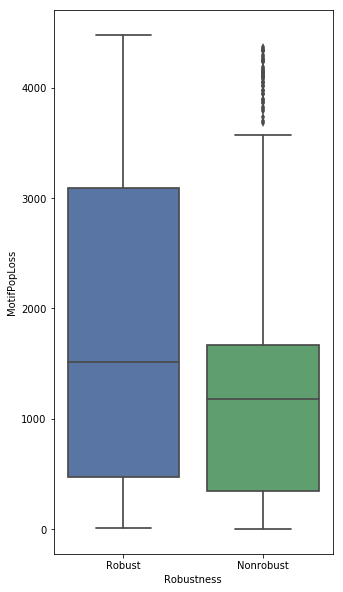

In [57]:
import seaborn as sns
fig, (ax2) = plt.subplots(ncols=1)
sns.set(font_scale = 2)
sns.set_style('whitegrid')
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(5,10)
sns.boxplot(x='Robustness',y='MotifPopLoss',data=dataframe1,)


In [73]:
import pandas as pd
dataframe1=pd.read_csv('H1N1500SimLowData.csv',index_col=0)
dataframe2=pd.read_csv('H1N1500SimLowDataEventDetails.csv',index_col=0)
dataframe1ATA=pd.read_csv('H1N11000SimHighGainOtherIleATAData.csv',index_col=0)
dataframe2ATA=pd.read_csv('H1N11000SimHighGainOtherIleATADataEventDetails.csv',index_col=0)
b=pd.read_csv('H1N1500SimHighData.csv',index_col=0)
c=pd.read_csv('H1N1500SimHighDataEventDetails.csv',index_col=0)
twomutgen=pd.read_csv('H1N1500SimLow2mutData.csv',index_col=0)
twomutdetail=pd.read_csv('H1N1500SimLow2mutDataEventDetails.csv',index_col=0)
twomutgenlowest=pd.read_csv('H1N1500SimLowest2mutData.csv',index_col=0)
twomutdetaillowest=pd.read_csv('H1N1500SimLowest2mutDataEventDetails.csv',index_col=0)
twopos=pd.read_csv('H1N1500SimHighest2posData.csv',index_col=0)
twoposdeet=pd.read_csv('H1N1500SimHighest2posDataEventDetails.csv',index_col=0)
dataframeList=[b,dataframe1ATA,dataframe1,twomutgen,twomutgenlowest,twopos]

In [51]:
dataframeList[1]

,Replicate,MotifPop,MotifIndieEvo
0,0,1,1
1,1,3,1
2,2,184,9
3,3,1,1
4,5,7,1
5,12,1,1
6,13,16,5
7,14,1,1
8,15,3,1
9,19,1,1


In [80]:
high='AGGAGGGGTATCAACGGTGCA'
highATA='AGGAGGGGTATAAACGGTGCA'
low='AGGAGGGGTCGCAACGGTGCA'
twolow='AGGAGGGGTGTCAACGGTGCA'
twolowest='AGGAGGGGTCAAAACGGTGCA'
twoposAA='TGGAGGGGTATCAACGGTGCA'
seqs=[high,highATA,low,twolow,twolowest,twoposAA]
cols1=['ProtSeq','NucSeq','Independent Evolution','Trees with Motif (%)','Avg # strains with motif per tree']
dataList1=[]
for i in range(len(seqs)):
    dataList1.append([CommonMotifProb.translateRNA(seqs[i]),seqs[i],np.sum(dataframeList[i]['MotifIndieEvo']),len(dataframeList[i])/10.0,np.mean(dataframeList[i]['MotifPop'])])



dataframe1=pd.DataFrame(dataList1,columns=cols1)
#dataframe1
dataframe1.to_csv('SummarySimdatawithATA_forThesis.csv')

In [397]:
twomutgenlowest['MotifPop'][27]

40

In [64]:

seqs=[high,highATA,low,twolow,twolowest,twoposAA]
print seqs
cols1=['Seq','Strains with motif (per tree)']
dataList1=[]
for i in range(len(seqs)):
    for j in range(len(dataframeList[i])):
        #print i
        CommonMotifProb.translateRNA(seqs[i])

        dataList1.append([seqs[i],dataframeList[i]['MotifPop'][j]])



dataframe1=pd.DataFrame(dataList1,columns=cols1)
dataframe1

['AGGAGGGGTATCAACGGTGCA', 'AGGAGGGGTATAAACGGTGCA', 'AGGAGGGGTCGCAACGGTGCA', 'AGGAGGGGTGTCAACGGTGCA', 'AGGAGGGGTCAAAACGGTGCA', 'TGGAGGGGTATCAACGGTGCA']


,Seq,Strains with motif (per tree)
0,AGGAGGGGTATCAACGGTGCA,1
1,AGGAGGGGTATCAACGGTGCA,5
2,AGGAGGGGTATCAACGGTGCA,1
3,AGGAGGGGTATCAACGGTGCA,3
4,AGGAGGGGTATCAACGGTGCA,52
5,AGGAGGGGTATCAACGGTGCA,7
6,AGGAGGGGTATCAACGGTGCA,70
7,AGGAGGGGTATCAACGGTGCA,76
8,AGGAGGGGTATCAACGGTGCA,7
9,AGGAGGGGTATCAACGGTGCA,7


In [52]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import ttest_ind
# seed the random number generator
for i in range(len(dataframeList)):
    for j in range(len(dataframeList)):
        data1=dataframeList[i]['MotifPop']
        data2=dataframeList[j]['MotifPop']
        print CommonMotifProb.translateRNA(seqs[i]),CommonMotifProb.translateRNA(seqs[j])
# compare samples
        stat, p = ttest_ind(data1, data2)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
        alpha = 0.05
        if p > alpha:
            print('Same distributions (fail to reject H0)')
        else:
            print('Different distributions (reject H0)')

RRGINGA RRGINGA
Statistics=0.000, p=1.000
Same distributions (fail to reject H0)
RRGINGA RRGINGA
Statistics=1.107, p=0.269
Same distributions (fail to reject H0)
RRGINGA RRGRNGA
Statistics=1.700, p=0.090
Same distributions (fail to reject H0)
RRGINGA RRGVNGA
Statistics=2.500, p=0.013
Different distributions (reject H0)
RRGINGA RRGQNGA
Statistics=1.646, p=0.100
Same distributions (fail to reject H0)
RRGINGA WRGINGA
Statistics=2.306, p=0.021
Different distributions (reject H0)
RRGINGA RRGINGA
Statistics=-1.107, p=0.269
Same distributions (fail to reject H0)
RRGINGA RRGINGA
Statistics=0.000, p=1.000
Same distributions (fail to reject H0)
RRGINGA RRGRNGA
Statistics=0.574, p=0.566
Same distributions (fail to reject H0)
RRGINGA RRGVNGA
Statistics=1.328, p=0.185
Same distributions (fail to reject H0)
RRGINGA RRGQNGA
Statistics=1.316, p=0.189
Same distributions (fail to reject H0)
RRGINGA WRGINGA
Statistics=1.664, p=0.097
Same distributions (fail to reject H0)
RRGRNGA RRGINGA
Statistics=-1.700

In [63]:
dataframe1

,Seq,Strains with motif (per tree)
0,RRGINGA,1
1,RRGINGA,5
2,RRGINGA,1
3,RRGINGA,3
4,RRGINGA,52
5,RRGINGA,7
6,RRGINGA,70
7,RRGINGA,76
8,RRGINGA,7
9,RRGINGA,7


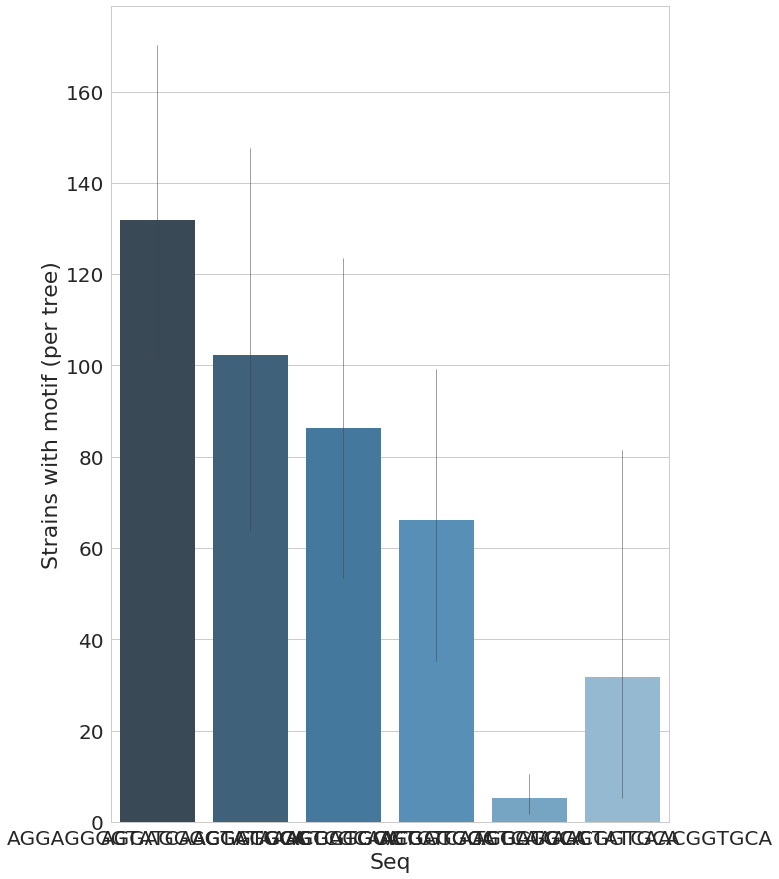

In [69]:

import seaborn as sns
fig, (ax2) = plt.subplots(ncols=1)
sns.set(font_scale = 2)
sns.set_style('whitegrid')
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(10,15)
sns.barplot(x='Seq',y='Strains with motif (per tree)',data=dataframe1,palette="Blues_d",errwidth=0.5)


#import seaborn as sns, matplotlib.pyplot as plt

#tips = sns.load_dataset("tips")
#sns.boxplot(x="day", y="total_bill", data=tips, palette="PRGn")

# statistical annotation
#x1, x2 = 2, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = tips['total_bill'].max() + 2, 2, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

In [70]:
fig.savefig("StrainMotifEvoGainSim.pdf", fomrat='pdf')

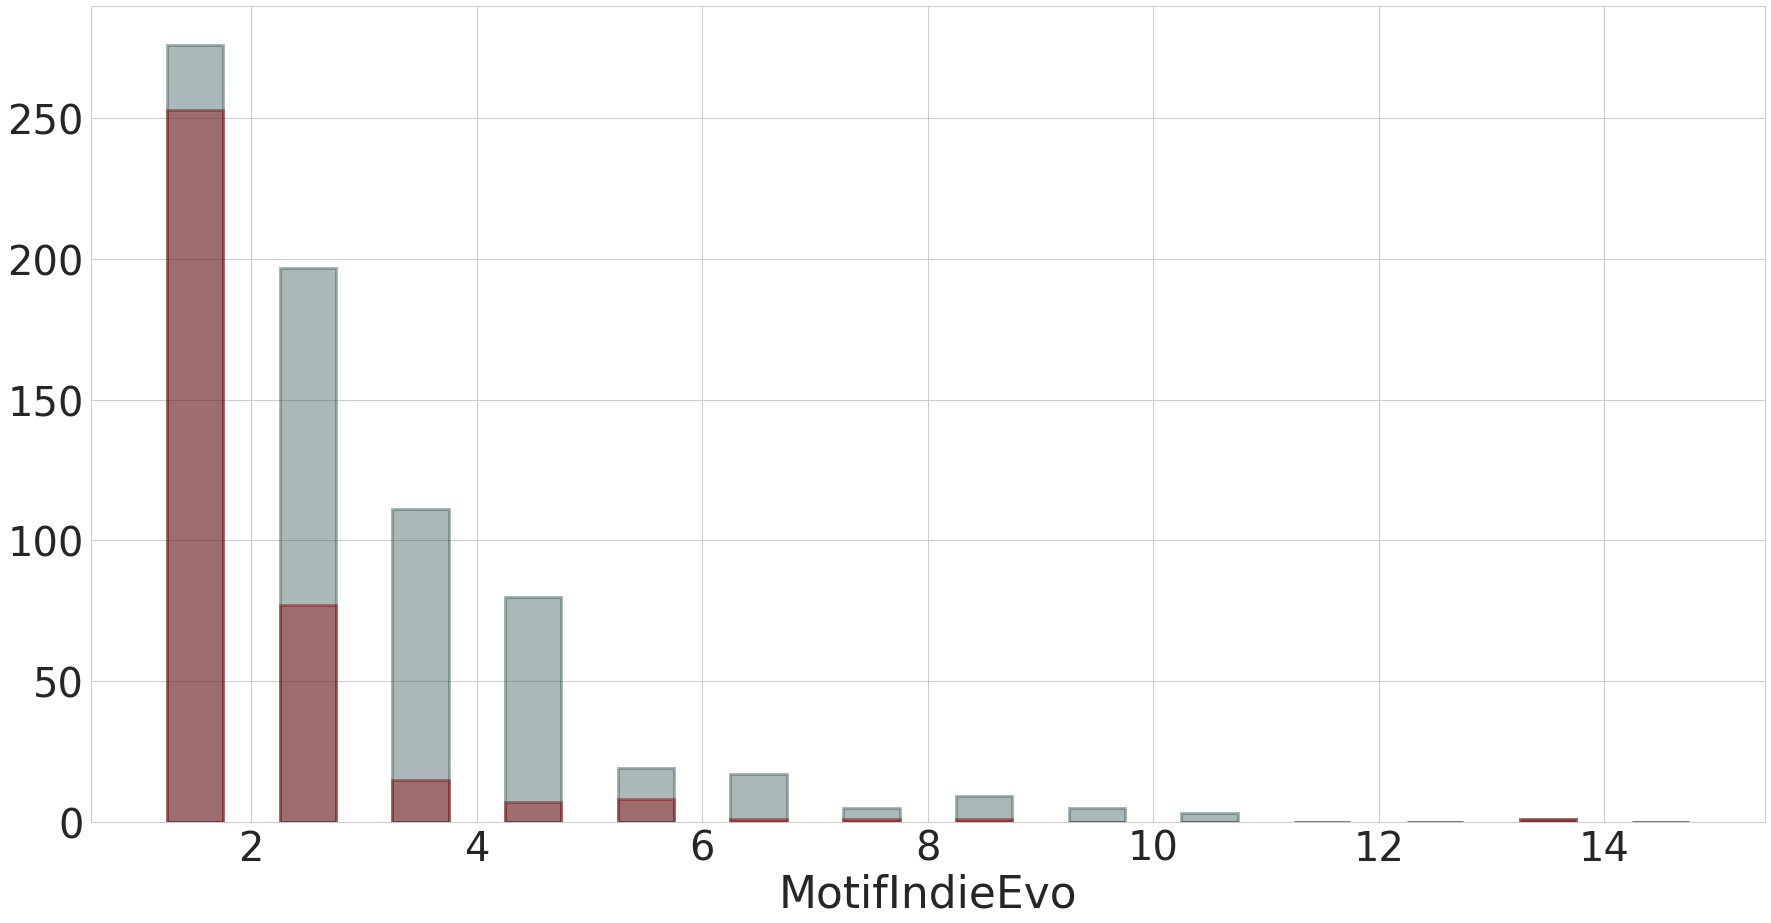

In [78]:
import seaborn as sns
fig, (ax2) = plt.subplots(ncols=1)
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(30,15)
sns.set(font_scale = 4)
sns.set_style('whitegrid')
colours=["darkslategrey","darkred","coral"]
labels=['Robust','Non-Robust']
#for i in listofcodons:

ax2=sns.distplot(b['MotifIndieEvo'],color="darkslategrey",   label='Robust', kde=False,bins=np.arange(1, 16, 1),hist_kws={'rwidth':0.5, 'edgecolor':"darkslategray","linewidth": 3})
ax2=sns.distplot(dataframe1['MotifIndieEvo'],color="darkred", label='Not Robust', kde=False,bins=np.arange(1, 16, 1),hist_kws={'rwidth':0.5,'edgecolor':"darkred", "linewidth": 3})
#ax2=sns.distplot(twomutgen['MotifIndieEvo'],color="darkorange", label='Not Robust', kde=False,bins=np.arange(1, 13, 1),hist_kws={'rwidth':0.7,'edgecolor':"orange", "linewidth": 3})
#ax2=sns.distplot(twopos['MotifIndieEvo'],color="teal", label='Not Robust', kde=False,bins=np.arange(1, 16, 1),hist_kws={'rwidth':0.6,'edgecolor':"teal", "linewidth": 3})
#ax2=sns.distplot(twomutgenlowest['MotifIndieEvo'],color="gold", label='Not Robust', kde=False,bins=np.arange(1, 13, 1),hist_kws={'rwidth':0.5,'edgecolor':"gold", "linewidth": 3})

#ax2=sns.violinplot(data=[b[b['MotifIndieEvo']!=0]['MotifIndieEvo'],dataframe1[dataframe1['MotifIndieEvo']!=0]['MotifIndieEvo']],inner=None)
#ax2=sns.swarmplot(data=[b[b['MotifIndieEvo']!=0]['MotifIndieEvo'],dataframe1[dataframe1['MotifIndieEvo']!=0]['MotifIndieEvo']],size=10)


In [79]:
fig.savefig("IndEvoEventsPerTreeGainSim.pdf",format='pdf')

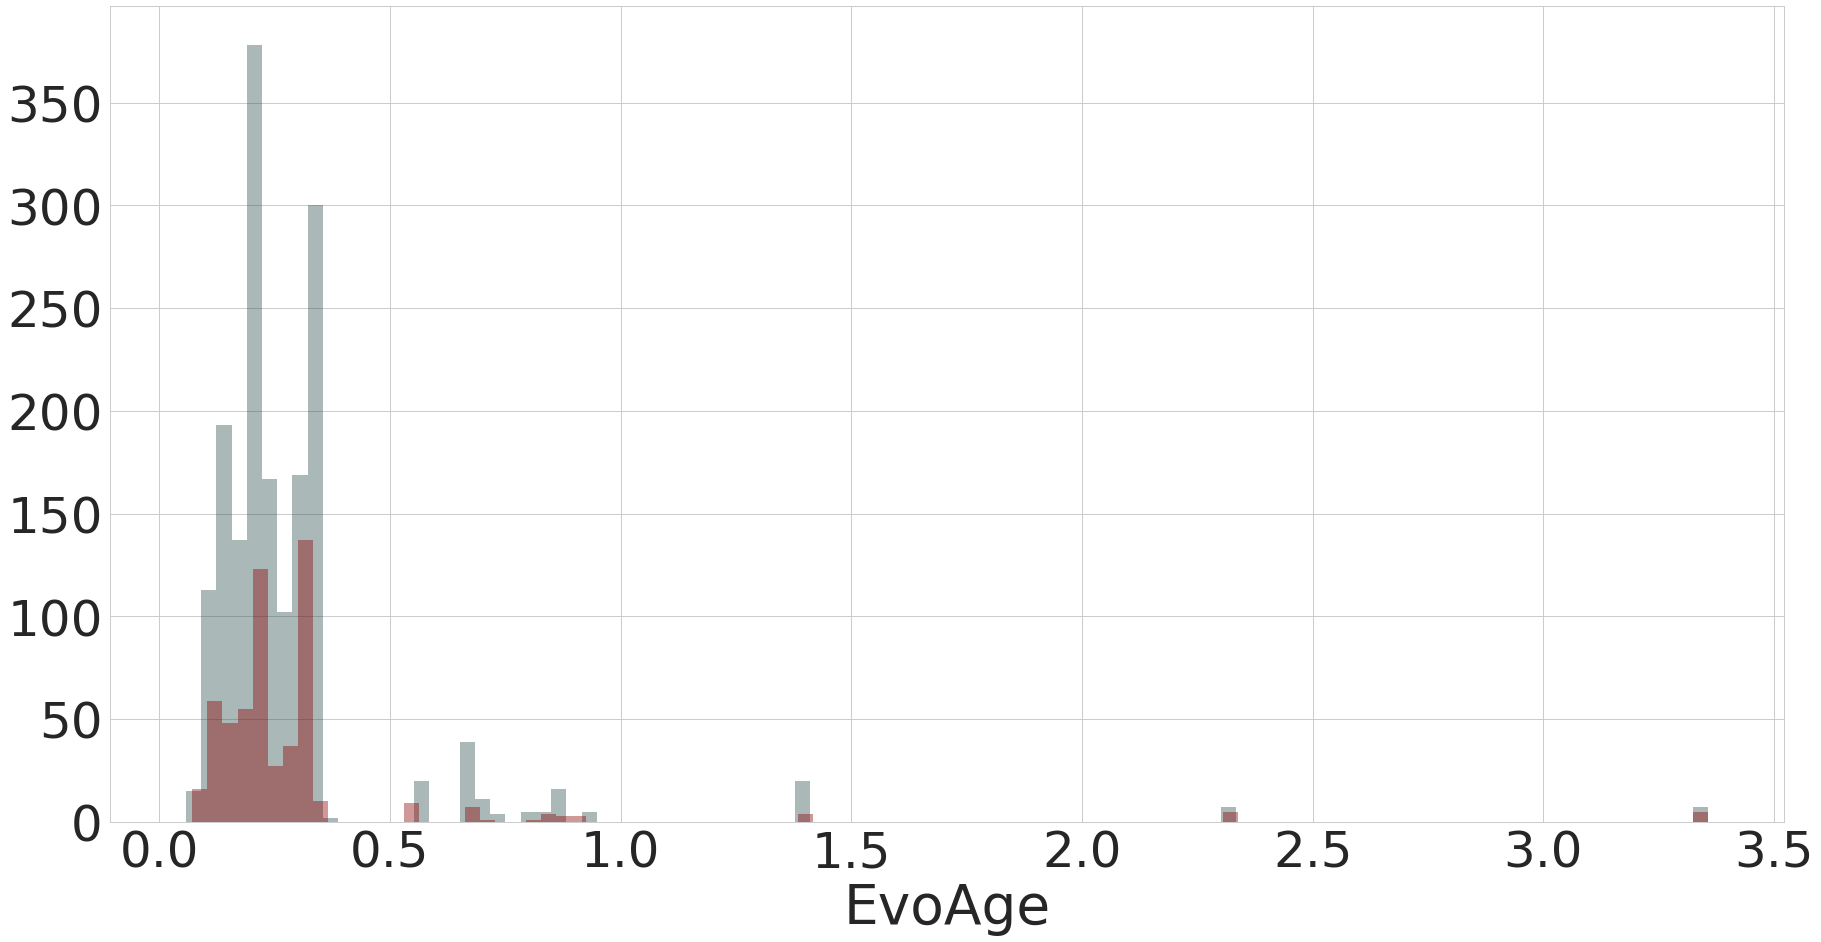

In [21]:
import seaborn as sns
fig, (ax2) = plt.subplots(ncols=1)
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(30,15)
colours=["darkslategrey","darkred","coral"]
labels=['Robust','Non-Robust']
#for i in listofcodons:
ax2=sns.distplot(c['EvoAge'],color="darkslategrey",   label='Robust', kde=False,bins=100)
ax2=sns.distplot(dataframe2['EvoAge'],color="darkred", label='Not Robust', kde=False,bins=100)
#ax2=sns.violinplot(data=[b[b['MotifIndieEvo']!=0]['MotifIndieEvo'],dataframe1[dataframe1['MotifIndieEvo']!=0]['MotifIndieEvo']],inner=None)
#ax2=sns.swarmplot(data=[b[b['MotifIndieEvo']!=0]['MotifIndieEvo'],dataframe1[dataframe1['MotifIndieEvo']!=0]['MotifIndieEvo']],size=10)


In [325]:
print np.mean(c['EvoAge'])
print np.mean(dataframe2['EvoAge'])

0.293516750872
0.311127856441


In [336]:
a= dataframe2[dataframe2['EvoAge']<0.2 ]
d=c[c['EvoAge']<0.2 ]
twomuts= twomutdetail[twomutdetail['EvoAge']<0.2 ]
twomutslowest= twomutdetaillowest[twomutdetaillowest['EvoAge']<0.2 ]

print 'Average number of independent motif evolutions per tree where motif evolved'
print 'Low prob seq:',np.mean(dataframe1['MotifIndieEvo'])
print 'High prob seq:',np.mean(b['MotifIndieEvo'])
print 'Two mut low prob seq:',np.mean(twomutgen['MotifIndieEvo'])
print 'Two mut lowest prob seq:',np.mean(twomutgenlowest['MotifIndieEvo'])
print 'Two codon pos highest prob seq:',np.mean(twopos['MotifIndieEvo'])
print '\n'
print 'Total independent motif evolutionary events'
print 'Low prob seq:',np.sum(dataframe1['MotifIndieEvo'])
print 'High prob seq:',np.sum(b['MotifIndieEvo'])
print 'Two mut low prob seq:',np.sum(twomutgen['MotifIndieEvo'])
print 'Two mut lowest prob seq:',np.sum(twomutgenlowest['MotifIndieEvo'])
print 'Two codon pos highest prob seq:',np.sum(twopos['MotifIndieEvo'])
print '\n'
print 'Total number of phylogenies where motif evolved at least once'
print 'High prob seq:',len(b)
print 'Low prob seq:',len (dataframe1)
print 'Two mut low prob seq:',len(twomutgen)
print 'Two mut lowest prob seq:',len(twomutgenlowest)
print 'Two codon pos highest prob seq:',len(twopos)
print '\n'
print 'Age bins, number of young evolutionary events (below branchlength 0.2)'
print 'High prob seq:',len(d)
print 'Low prob seq:',len(a)
print 'Two mut low prob seq:',len(twomuts)
print 'Two mut lowest prob seq:',len(twomutslowest)

#a

d


Average number of independent motif evolutions per tree where motif evolved
Low prob seq: 1.52197802198
High prob seq: 2.37206085754
Two mut low prob seq: 1.83967391304
Two mut lowest prob seq: 1.17647058824
Two codon pos highest prob seq: 1.58928571429


Total independent motif evolutionary events
Low prob seq: 554
High prob seq: 1715
Two mut low prob seq: 677
Two mut lowest prob seq: 40
Two codon pos highest prob seq: 178


Total number of phylogenies where motif evolved at least once
High prob seq: 723
Low prob seq: 364
Two mut low prob seq: 368
Two mut lowest prob seq: 34
Two codon pos highest prob seq: 112


Age bins, number of young evolutionary events (below branchlength 0.2)
High prob seq: 528
Low prob seq: 172
Two mut low prob seq: 98
Two mut lowest prob seq: 3


,Replicate,Strain,EvoAge,TotWithNewEvoMotif
4,2,1995|Swine|A/swine/Germany/Vi5698/1995|Germany...,0.194267,1
5,5,NODE2011,0.127205,3
7,6,1981|Avian|A/pigeon/MN/1407/1981|USA|H1N1,0.125102,1
8,6,NODE5975,0.100463,50
10,7,NODE3693,0.071003,2
13,8,1983|Human|A/Memphis/6/1983|USA|H1N1,0.158228,1
14,8,NODE3693,0.071003,69
15,9,NODE1466,0.180425,7
16,9,NODE6873,0.127950,2
17,9,NODE8435,0.174619,67


In [295]:
##determine the number of descendant leaves that a switch event affected, ie after switch how many children have the same genotype?

for node in H1N1Tree.preorder_node_iter():
    retainedmotiflist=[]
    if node.label:
        nodelabel=node.label

        if Treemotif1[nodelabel].switchnode==True:

            for lode in node.leaf_nodes():
                if Treemotif1[lode.taxon.label].upstreamswitch.label==nodelabel:
                    retainedmotiflist.append(lode)

            print k, nodelabel, Treemotif1[nodelabel].hasMotif
            print len(node.leaf_nodes()),len(retainedmotiflist)
#                    if len(retainedmotiflist)>100 and len(retainedmotiflist)<200:
#                        for n in retainedmotiflist:
#                            print n.taxon.label

        #print len([nodel for nodel in node.inorder_iter()])


MOD_PKA_1 NODE3713 True
89 36
MOD_PKA_1 NODE3794 False
2 2
MOD_PKA_1 NODE3836 False
43 43
MOD_PKA_1 NODE5128 False
3 3
MOD_PKA_1 NODE5193 False
5 5


In [77]:
nodeage=[]
for node in H1N1Tree.preorder_node_iter():


    tempanc=node#.parent_node
    sumage=0
    while tempanc!=None:

        sumage=sumage+tempanc.edge_length
        tempanc=tempanc.parent_node


    nodeage.append(sumage)
    

In [97]:
print sorted(nodeage)

[0.0513160858159, 0.05767558177527, 0.07100339643867, 0.07119421061056999, 0.074494622265, 0.07449562226550002, 0.07727819175164, 0.09570229523083999, 0.09797286727243999, 0.09797386727294002, 0.09813988167957, 0.10046276867107, 0.10334677153971, 0.10419551908940003, 0.10472312580937, 0.10544325458327, 0.10544425458377003, 0.10679946449435, 0.10761405839846999, 0.10831135810104003, 0.10831235810154005, 0.10934232988024, 0.10934332988074003, 0.10957223269895999, 0.10957323269946004, 0.11001805592514, 0.11070709186029, 0.11071743203965002, 0.11096697782438, 0.11096797782488003, 0.11112885687640003, 0.11145699461646999, 0.11172020482581, 0.11274879203096999, 0.11274979203147002, 0.11275079203197005, 0.11275079203197005, 0.11279966463136, 0.11322431622501, 0.11347911557407003, 0.11382840462310002, 0.1141297717848, 0.11474690213820003, 0.11474790213870006, 0.11508995003325004, 0.11549585608546, 0.11549867716689005, 0.11549967716739008, 0.11597941281464, 0.11625937740224003, 0.11626006653731

(array([  7.00000000e+00,   4.70000000e+01,   2.28000000e+02,
          1.94000000e+02,   1.10300000e+03,   2.84000000e+02,
          1.36000000e+02,   1.96000000e+02,   2.28300000e+03,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.10000000e+01,   3.30000000e+01,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.30000000e+01,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

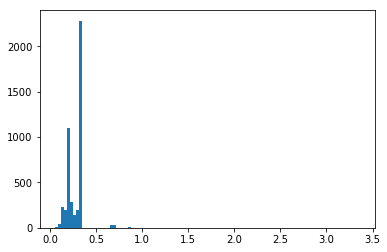

In [83]:
#print sorted(nodeage)
plt.hist(nodeage,bins=100)